In [2]:
from collections import defaultdict
import os
import sys 
from tqdm import tqdm
import itertools
import utils.file_utils as utils
sys.path.append("/data/jeff-law/projects/fungcat-function-prediction/src")
#sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__file__)))))
import fungcat_settings as f_settings
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
from scipy.stats import kruskal, mannwhitneyu
print("python version: %s" % (sys.version.split('\n')[0]))
print("matplotlib version: %s" % (matplotlib.__version__))
print("pandas version: %s" % (pd.__version__))
print("seaborn version: %s" % (sns.__version__))
print("numpy version: %s" % (np.__version__))
print("scipy version: %s" % (scipy.__version__))

python version: 2.7.12 (default, Nov 12 2018, 14:36:49) 
matplotlib version: 2.0.0
pandas version: 0.22.0
seaborn version: 0.7.1
numpy version: 1.14.2
scipy version: 1.1.0


/home/jeffl/.local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
os.chdir("../..")

In [4]:
alg_name = {'sinksource-squeeze': 'SinkSource Squeeze', 
            'localplus': 'Local+', 'local': 'Local',
#             'localplus': 'Blast Avg.', 'local': 'Local',
            'sinksource': 'SinkSource', 'sinksourceplus': 'SinkSource+',
           'birgrank': 'BirgRank', 'genemania': 'GeneMANIA', 'aptrank': 'AptRank OneWay'}

In [48]:
def get_results(version, exp_names, algorithms, unweighted='', 
                alpha_list=["0_8"], theta_list=[None], mu_list=[None], lambda_list=[None], tol_list=[""],
                ss_alpha="0_8", maxi_list=[], ss_maxi="eps0_0-maxi20", exp_type="ground-truth", verbose=False):
    df_all = pd.DataFrame()
    for exp_name in exp_names:
        loaded = {alg: False for alg in algorithms}
        read_files = set()
        for alg in algorithms:
            if loaded[alg] is True:
                print("Warning! %s being loaded again for %s" % (alg, exp_name))
            # load the results table
            results_dir = "outputs/%s/all/%s/%s" % (version, alg, exp_name)
            for alpha, theta, mu, br_lambda, maxi, tol in itertools.product(*[
                alpha_list, theta_list, mu_list, lambda_list, maxi_list, tol_list]):
                if tol != "":
                    # tol should only be for genemania
                    if alg != "genemania":
                        continue
                    results_file = "%s/%s%s-%sl0-a%s%s%s.txt" % (
                        results_dir, 'all-sp-' if keep_ann!='' else '', exp_type, unweighted, alpha, maxi, tol)
                elif alg == 'birgrank' and (theta is not None and mu is not None and br_lambda is not None):
                    results_file = "%s/%s%s-%sl0-a%s%s%s%s%s%s.txt" % (
                        results_dir, 'all-sp-' if keep_ann!='' else '', exp_type,
                        "swsn-" if 'string' in version and unweighted in ["", "goterm-weight-"] else unweighted, # BirgRank can't use goterm-weight, so don't include it
                        alpha, maxi, 
                        theta, mu, br_lambda, "a0_5" if maxi == "" else "")
#                         results_dir, unweighted, alpha, theta, mu, alpha)
                elif alg == 'aptrank':
                    results_file = "%s/%s%s-%sl0%s-k8-s5-t0_5-%sa%s%s.txt" % (
                        results_dir, 'all-sp-' if keep_ann!='' else '', exp_type,
                        "swsn-" if unweighted not in ["unw-"] else '', 
                        br_lambda, "oneway", alpha, maxi)
                else:
                    results_file = "%s/%s%s-%sl0-a%s%s.txt" % (
                        results_dir, 'all-sp-' if keep_ann!='' else '', exp_type, unweighted, alpha, maxi)
                if verbose:
                    print("Reading results from %s" % (results_file))
                if not os.path.isfile(results_file):
                    if verbose:
                        print("\tdoesn't exist. Skipping")
                    continue
                if results_file in read_files:
                    # don't read a file twice. This happens to BirgRank if we are using multiple different max_iters
                    continue
                read_files.add(results_file)
                # results_file_template = "%s/groundtruth-l0-a0_8.txt" % (results_dir)
                
                # now read the file
                df = pd.read_csv(results_file, sep='\t', header=[0])
                # and set the name of the algorithm in the dataframe appropriately 
                if alg == "birgrank" and alpha == "0_5" and theta == "0_5" and mu == "0_5":
                    df['Algorithm'] = alg_name[alg]
                    loaded[alg] = True
                elif alg == "birgrank":
                    df['Algorithm'] = 'birgrank a%s%s%s%s%s' % (alpha, theta, mu, br_lambda, maxi)
#                 elif alg == "sinksource" and alpha != "1_0":
                elif alg == "sinksource" and (alpha != ss_alpha or maxi != ss_maxi):
                    df['Algorithm'] = 'sinksource a%s %s' % (alpha, maxi)
#                     print("\t keeping only alpha %s for now" % (ss_alpha))
#                     continue
                else:
                    df['Algorithm'] = alg_name[alg]
                    if verbose:
                        print("%d sp-goterm pairs" % (len(df['Algorithm'])))
                    loaded[alg] = True

#                 print(df.head())
                # I changed '# ann' to be the more correct '# test ann', but am changing it back here to match previous files 
                if '# test ann' in df.columns:
                    df.rename(columns={'# test ann':'# ann'}, inplace=True)
                df_all = pd.concat((df_all, df))
    return df_all

In [6]:
# also read in the prots annotated to each GO term
def parse_pos_neg_file(pos_neg_file, goterms=None):
    print("Reading positive and negative annotations for each protein from %s" % (pos_neg_file))
    goid_prots = {}
    with open(pos_neg_file, 'r') as f:
        for line in f:
            if line[0] == '#':
                continue
            goid, pos_neg_assignment, prots = line.rstrip().split('\t')[:3]
            if goterms and goid not in goterms:
                continue
            prots = set(prots.split(','))
            if int(pos_neg_assignment) == 1:
                goid_prots[goid] = prots
    return goid_prots

def get_species_prot_counts(goid_prots, species_to_uniprot, selected_species=None, goids=None):
    print("Getting annotation counts per species")
    if selected_species is None:
        selected_species = species_to_uniprot.keys()
    if goids is None:
        goids = goid_prots.keys()
    species_prot_counts = {}
    for s in selected_species:
        species_prots = species_to_uniprot[str(int(s))]
        #print("species: %s, %d prots" % (s, len(species_prots)))
#         total_prots = set()
        total_ann = 0
        for goid in goids:
            if goid not in goid_prots:
                continue
            s_prots = goid_prots[goid] & species_prots
#             total_prots.update(s_prots)
            total_ann += len(s_prots)
        species_prot_counts[s] = total_ann
        
    return species_prot_counts

ev_codes = "exp"
pos_neg_files = [
        "inputs/pos-neg/%s/pos-neg-bp-50-list.tsv" % (ev_codes), 
        "inputs/pos-neg/%s/pos-neg-mf-50-list.tsv" % (ev_codes),
]
exp_goid_prots = {}
for pos_neg_file in pos_neg_files:
    exp_goid_prots.update(parse_pos_neg_file(pos_neg_file))
    

# ev_codes = "rem-neg-iea"
ev_codes = "comp"
pos_neg_files = [
        "inputs/pos-neg/%s/pos-neg-bp-5-list.tsv" % (ev_codes), 
        "inputs/pos-neg/%s/pos-neg-mf-5-list.tsv" % (ev_codes),
]
comp_goid_prots = {}
for pos_neg_file in pos_neg_files:
    comp_goid_prots.update(parse_pos_neg_file(pos_neg_file))

ev_codes = "iea"
pos_neg_files = [
        "inputs/pos-neg/%s/pos-neg-bp-10-list.tsv" % (ev_codes), 
        "inputs/pos-neg/%s/pos-neg-mf-10-list.tsv" % (ev_codes),
]
iea_goid_prots = {}
for pos_neg_file in pos_neg_files:
    iea_goid_prots.update(parse_pos_neg_file(pos_neg_file))

Reading positive and negative annotations for each protein from inputs/pos-neg/exp/pos-neg-bp-50-list.tsv
Reading positive and negative annotations for each protein from inputs/pos-neg/exp/pos-neg-mf-50-list.tsv
Reading positive and negative annotations for each protein from inputs/pos-neg/comp/pos-neg-bp-5-list.tsv
Reading positive and negative annotations for each protein from inputs/pos-neg/comp/pos-neg-mf-5-list.tsv
Reading positive and negative annotations for each protein from inputs/pos-neg/iea/pos-neg-bp-10-list.tsv
Reading positive and negative annotations for each protein from inputs/pos-neg/iea/pos-neg-mf-10-list.tsv


In [7]:
def split_results_by_cutoffs(df_all, cutoffs, 
                             exp_goid_prots, comp_goid_prots, iea_goid_prots, 
                             overall_goid_prots=None):
    # now limit it to the current GO term split
    cutoffs_data = []
    for cutoff1, cutoff2 in cutoffs:
        print(cutoff1, cutoff2)
#         if split_by_overall_counts is True:
            # group the goids by the # of ann in all 19 species
            # this would be the # of annotations in the evaluation group
            # we want the # of annotations with the training evidence codes
            #num_ann = df_all[df_all['Algorithm'] == 'SinkSource'][['goid', '# ann']].groupby("goid").sum()
        if overall_goid_prots is not None:
            print("\tusing splits over all species")
            curr_goids = set([g for g, prots in overall_goid_prots.items() if len(prots) >= cutoff1 and len(prots) < cutoff2])
            df_curr = df_all[df_all['goid'].isin(curr_goids)]
            # also only keep those that have at least 10 in the evaluated species
            df_curr = df_curr[(df_curr['# ann'] >= 10)]
        else:
            print("\tusing splits for each individual species")
#             col = '# ann' if '# ann' in df_curr.columns else '# test ann'
            col = '# ann'
            df_curr = df_all[(df_all[col] >= cutoff1) & (df_all[col] < cutoff2)] 
        if keep_ann != '':
            # species are not split
            species_exp_counts = {}
            species_comp_counts = {}
            species_iea_counts = {}
        else:
            species_exp_counts = get_species_prot_counts(exp_goid_prots, species_to_uniprot, 
                                                          selected_species=df_curr['#taxon'].unique(), 
                                                          goids=set(df_curr['goid'].values))
            species_comp_counts = get_species_prot_counts(comp_goid_prots, species_to_uniprot, 
                                                          selected_species=df_curr['#taxon'].unique(), 
                                                          goids=set(df_curr['goid'].values))
            species_iea_counts = get_species_prot_counts(iea_goid_prots, species_to_uniprot, 
                                                          selected_species=df_curr['#taxon'].unique(), 
                                                          goids=set(df_curr['goid'].values))
        cutoffs_data.append((df_curr, species_exp_counts, species_comp_counts, species_iea_counts))
    return cutoffs_data

In [42]:
# main cell for getting the data
algorithms = ["sinksource", "genemania", "birgrank", "localplus"]
# versions = ["2018_06-seq-sim-e0_1",]
versions = ["2018_06-seq-sim-e0_1-string",]
# versions = ["2018_09-s200-seq-sim-e0_1",]
selected_species = utils.readDict(f_settings.VERSION_SELECTED_STRAINS[versions[0]], 1, 2)
uniprot_to_species = utils.readDict(f_settings.VERSION_UNIPROT_TO_SPECIES[versions[0]], 1,2)
# also build the reverse
species_to_uniprot = {s: set() for s in selected_species}
for p in uniprot_to_species:
    species_to_uniprot[str(uniprot_to_species[p])].add(p)
# measures = ['avgp', 'auprc', 'auroc']
measures = ['fmax']
alpha_list = ["1_0", "0_95", "0_5"]
theta_list = ["-t0_5"]
mu_list = ["-m0_5"]
# I forgot to include the lambda parameter before, meaning "" = 1
lambda_list = ["", "-l0_5", "-l0_01"]
# use these settings for previous results
exp_type = "loso"
maxi_list = ["-eps0_0001-maxi1000"]
unweighted = ""
ev_code_list = [
    ("expc-rem-neg-comp-iea", "-core", ""),
#     ("expc-comp-rem-neg-iea", "comp", ""),
#     ("expc-comp", "iea", ""),
#     ("expc-comp-rem-neg-iea", "iea", ""),
#     ("expc-comp-rem-neg-iea", "iea-core", ""),
]
ev_code_list2 = []
# for h in ['bp', 'mf']:
for h in ['bp']:
    for l in ev_code_list:
        ev_code_list2.append(list(l)+[h])
ev_code_list = ev_code_list2
print(ev_code_list)

[['expc-rem-neg-comp-iea', '-core', '', 'bp']]


In [63]:
algorithms = ["birgrank"]
# compare_type = "compare-lambda"
# lambda_list = ["", "-l0_99", "-l0_9", "-l0_75", "-l0_5", "-l0_25", "-l0_1", "-l0_01", "-l0_0"]
# lambda_list = ["-l0_01"]
compare_type = "compare-mu-l0_01"
# mu_list = ["-m0_99", "-m0_9", "-m0_75", "-m0_5", "-m0_25", "-m0_1", "-m0_01"]
compare_type = "compare-alpha-l0_01"
# lambda_list = [""]
# lambda_list = ["-l0_5"]
lambda_list = ["-l0_01"]
# alpha_list = ["1_0", "0_99", "0_95", "0_9", "0_75", "0_5", "0_25", "0_1", "0_01"]
compare_type = "compare-alpha-eps-l0_01"
alpha_list = ["0_95", "0_9"]
maxi_list = ["-eps0_0001-maxi1000", "-eps1e-05-maxi1000", "-eps1e-06-maxi1000"]

In [64]:
# now get the results
ev_code_results = {}
df_all = None
for ev_codes, eval_ev_codes, keep_ann, h in ev_code_list:
    with_neg = '-use-neg'
#     with_neg = '-non-pos-neg'
    split_overall = False
    ss_alpha = "0_95"
    # use this to select which max iters to use for SS
    # unfortunately, I kept the eps and maxi (20) in the file name for GM and Local+ even though they aren't used
    ss_maxi = "-eps0_0-maxi10"
    exp_names = ["%s-50-1000%s-%s%s%s" % (ev_codes, eval_ev_codes, h, with_neg, keep_ann)]
    sort_taxon_by_fmax = {}
    for version in versions:
        print(version, ev_codes, eval_ev_codes, keep_ann, h)
        # wasn't conistent with dashes
        eval_str = "-"+eval_ev_codes if len(eval_ev_codes) > 1 and eval_ev_codes[0] != "-" else eval_ev_codes
        out_dir = "outputs/viz/eval-loso/%s%s/%s" % (ev_codes, eval_str, version)
        utils.checkDir(out_dir)
        unweighted = ''
        if 'string' in version:
            unweighted = "goterm-weight-"
        df_all = get_results(version, exp_names, algorithms, unweighted=unweighted,
                            alpha_list=alpha_list, theta_list=theta_list, mu_list=mu_list, lambda_list=lambda_list,
                            ss_alpha=ss_alpha, exp_type=exp_type, maxi_list=maxi_list, ss_maxi=ss_maxi, 
                            tol_list=["", "-tol1e-05"],
                             )
#                              verbose=True)     

        if len(df_all) == 0:
            print("WARNING: no results found")
            continue        
        elif df_all.dtypes['# ann'] != 'int':
            print("WARNING: df contains incorrect datatypes. Please correct before continuing.")
            break
        cutoffs = [(10,5000)]
        overall_goid_prots = None
        cutoffs_data = split_results_by_cutoffs(df_all, cutoffs, exp_goid_prots, comp_goid_prots, iea_goid_prots, overall_goid_prots=overall_goid_prots)
        # store this for later
        ev_code_results[(version, ev_codes, eval_ev_codes, keep_ann, h)] = (cutoffs_data, out_dir)

('2018_06-seq-sim-e0_1-string', 'expc-rem-neg-comp-iea', '-core', '', 'bp')
(10, 5000)
	using splits for each individual species
Getting annotation counts per species
Getting annotation counts per species
Getting annotation counts per species


In [65]:
# use this to get the exact value of the median
# and test to see if each experiment has the same # of species - goterm pairs
for version, ev_codes, eval_ev_codes, keep_ann, h in sorted(ev_code_results, key=lambda x: (x[4], x[1], x[2], x[0])):
    cutoffs_data, out_dir = ev_code_results[(version, ev_codes, eval_ev_codes, keep_ann, h)]
    for df_curr, _,_,_ in cutoffs_data:
#         if h != "bp":
#             continue
        print(version, ev_codes, eval_ev_codes, keep_ann, h)
        # limit the goterms to those that are also present for SinkSource(?)
        for measure in measures:
#             print("measure: %s" % (measure))
            for alg in sorted(df_curr['Algorithm'].unique()):
                print("\t%s: %0.3f \t\t(%d sp-goterm pairs)" % (alg, df_curr[df_curr['Algorithm'] == alg][measure].median(), len(df_curr[df_curr['Algorithm'] == alg][measure])))

('2018_06-seq-sim-e0_1-string', 'expc-rem-neg-comp-iea', '-core', '', 'bp')
	birgrank a0_9-t0_5-m0_5-l0_01-eps0_0001-maxi1000: 0.471 		(787 sp-goterm pairs)
	birgrank a0_9-t0_5-m0_5-l0_01-eps1e-05-maxi1000: 0.471 		(787 sp-goterm pairs)
	birgrank a0_9-t0_5-m0_5-l0_01-eps1e-06-maxi1000: 0.471 		(787 sp-goterm pairs)
	birgrank a0_95-t0_5-m0_5-l0_01-eps0_0001-maxi1000: 0.474 		(787 sp-goterm pairs)
	birgrank a0_95-t0_5-m0_5-l0_01-eps1e-05-maxi1000: 0.474 		(787 sp-goterm pairs)
	birgrank a0_95-t0_5-m0_5-l0_01-eps1e-06-maxi1000: 0.474 		(787 sp-goterm pairs)


# Compare Distributions

Compare the distributions of scores when changing the birgrank parameters

In [39]:
df = df_curr
df.head()

,#taxon,goid,fmax,avgp,auprc,auroc,# ann,Algorithm
0,208964,GO:0016043,0.1003,0.0444,0.0576,0.3728,36,birgrank a0_99-t0_5-m0_5-l0_01
1,208964,GO:0071840,0.0997,0.0332,0.0464,0.3275,36,birgrank a0_99-t0_5-m0_5-l0_01
2,208964,GO:0022607,0.0968,0.0477,0.0663,0.5908,26,birgrank a0_99-t0_5-m0_5-l0_01
3,208964,GO:0044764,0.1600,0.0728,0.0812,0.5110,55,birgrank a0_99-t0_5-m0_5-l0_01
4,208964,GO:0006928,0.1786,0.1589,0.1688,0.5000,47,birgrank a0_99-t0_5-m0_5-l0_01


Writing to outputs/viz/eval-loso/expc-rem-neg-comp-iea-core/2018_06-seq-sim-e0_1-string/birgrank/10-1000-bp-compare-alpha-l0_01.pdf


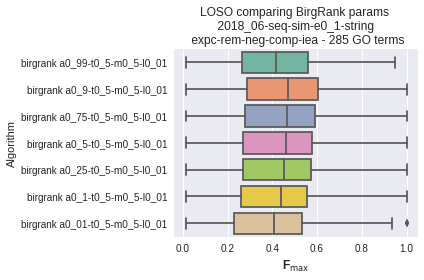

In [40]:
fig, ax = plt.subplots(figsize=(6,4))
# sns.boxplot(data=df, orient="h", order=max_iters_list, palette="Set2", ax=ax)
sns.boxplot(x="fmax", y="Algorithm", data=df, orient="h", palette="Set2", ax=ax)
plt.xlabel(r'F$_{\mathrm{max}}$', fontsize=12, fontweight='bold')
# plt.ylabel('# Iterations', fontsize=12, fontweight='bold')
plt.title("LOSO comparing BirgRank params \n %s \n %s - %d GO terms" % (
    version, ev_codes, len(df['goid'].unique())))
plt.tight_layout()

out_file = "outputs/viz/eval-loso/%s/%s/birgrank/10-1000-%s-%s.pdf" % (
    "%s%s" % (ev_codes, eval_ev_codes), versions[0], h, compare_type)
utils.checkDir(os.path.dirname(out_file))
print("Writing to %s" % (out_file))
plt.savefig(out_file)
plt.show()
plt.close()

# print("medians: %s" % (', '.join(["%s: %0.2f" % (str(a), df[a].median()) for a in df.columns])))

In [86]:
# now make a line plot of all of the values
def plot_fmax_med(df, out_file=None, xlabel='', ylabel='', title='', version_order=None):
    fig, ax = plt.subplots()
    ax = sns.pointplot(x='Algorithm', y='fmax', data=df, 
#                        orient='h',
#                  order=version_order, 
#                     hue='Algorithm', data=df_curr, orient='h')
#                    hue='Algorithm', hue_order=[alg_name[a] for a in algorithms],
#                   palette=my_palette, 
#                        estimator=np.median,
                       ci=None, 
#                        dodge=True, ci=95,
                 )
    plt.setp(ax.lines,linewidth=1)  # set lw for all lines of g axes

    if version_order is not None:
        ax.set_xticklabels([version_name[v] for v in version_order])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylim(0.3, 0.625)
    plt.title(title)
#     plt.xticks(rotation=45)
    if out_file is not None:
        print("Writing to %s" % (out_file))
        plt.savefig(out_file)
    plt.show()
    plt.close()

Writing to outputs/viz/eval-loso/expc-rem-neg-comp-iea-core/2018_06-seq-sim-e0_1-string/birgrank/10-1000-bp-compare-lambda.pdf


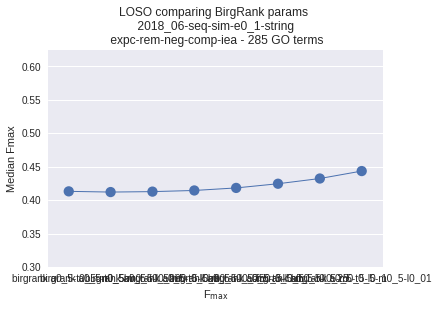

In [87]:
xlabel = r'F$_{\mathrm{max}}$'
# plt.ylabel('# Iterations', fontsize=12, fontweight='bold')
title = "LOSO comparing BirgRank params \n %s \n %s - %d GO terms" % (
    version, ev_codes, len(df['goid'].unique()))
# plt.tight_layout()

out_file = "outputs/viz/eval-loso/%s/%s/birgrank/10-1000-%s-%s.pdf" % (
    "%s%s" % (ev_codes, eval_ev_codes), versions[0], h, compare_type)
utils.checkDir(os.path.dirname(out_file))

plot_fmax_med(df, out_file=out_file, xlabel=xlabel, ylabel='Median Fmax', title=title)

## Summary Table
For every species, compare the median fmax distribution to each algorithm from SinkSource.

In [101]:
# make a table of median and median absolute deviation
# here's a quick function for median absolute deviation
def mad(x):
    med = np.median(x)
    return np.median(np.abs(x - med))

In [161]:
# check the status of the 19 species in the 200 species results
selected_species_19 = utils.readDict(f_settings.VERSION_SELECTED_STRAINS["2018_06-seq-sim-e0_1"], 1, 2)
print(selected_species_19.keys())

['272620', '632', '85962', '333849', '208964', '509170', '243277', '83332', '83333', '71421', '257313', '441771', '301447', '300267', '99287', '93061', '272563', '269482', '242231']


In [172]:
# get the # of species for which SS is statistically improved over the other methods
curr_h = 'bp'
# curr_h = 'mf'
eval_name = {"comp": "COMP", "iea": "ELEC"}
for version, ev_codes, eval_ev_codes, keep_ann, h in sorted(ev_code_results):
    if h != curr_h:
        continue
    cutoffs_data, out_dir = ev_code_results[(version, ev_codes, eval_ev_codes, keep_ann, h)]
    df_curr, _, _, _ = cutoffs_data[0]
    curr_species = df_curr['#taxon'].unique()
    print(version, ev_codes, eval_ev_codes, keep_ann, h, "%d species" % (len(curr_species)))
    
    # key is the algorithm being compared to sinksource, and value is the # of corrected p-values < 0.05
    alg_pvals = defaultdict(int)
#     alg1 = 'sinksource a1_0 -eps0_0001-maxi1000'
    alg1 = 'sinksource a1_0 -eps0_0-maxi1000'
#     alg1 = "sinksource a0_95 -eps0_0-maxi200"
#     for alg2 in sorted([a for a in algorithms if a != alg1]):
    for alg2 in sorted(df_curr['Algorithm'].unique()):
#     for alg2 in ["SinkSource"]:
        if alg1 == alg2:
            alg_pvals[alg1] = '-'
        for s in curr_species:
#             name = f_settings.NAME_TO_SHORTNAME2.get(selected_species[str(s)],'-')
            df_s = df_curr[df_curr['#taxon'] == s]
            a1_fmax = df_s[df_s['Algorithm'] == alg_name.get(alg1, alg1)][measure]
            a2_fmax = df_s[df_s['Algorithm'] == alg_name.get(alg2, alg2)][measure]
            try:
                test_statistic, pval = mannwhitneyu(a1_fmax, a2_fmax, alternative='greater') 
#                 print(alg2, pval)
                if pval*len(curr_species) < 0.05:
                    alg_pvals[alg2] += 1
#                 if str(s) in selected_species_19:
#                     print("%s (%s): %s" % (s, selected_species_19[str(s)], pval*len(curr_species)))
#                 line = "%s\t%s\t%s\t%0.2e\t%0.2e" % (name, alg1, alg2, pval, pval*len(curr_species))
            except ValueError:
                pass
            
    print(alg_pvals)
    # alg, median fmax, MAD, # species for which SS is statisically significant 
    table = ["Algorithm\tMedian Fmax\tMAD Fmax\t # Sig. Sp. (out of %d)" % (len(curr_species))]
    for alg in sorted(df_curr['Algorithm'].unique()):
        x = df_curr[df_curr['Algorithm'] == alg_name.get(alg, alg)][measure]
        table.append("%s\t%0.3f\t%0.2f\t%s" % (alg_name.get(alg, alg), x.median(), mad(x), alg_pvals[alg]))
#             cutoff_sig[(cutoff1, cutoff2)][s] = pval
#             out_str += line+'\n'
    print('\n'.join(table))

('2018_09-s200-seq-sim-e0_1', 'expc-comp-rem-neg-iea', 'iea', '', 'bp', '200 species')
defaultdict(<type 'int'>, {'SinkSource': 185, 'sinksource a1_0 -eps0_0-maxi1000': '-', 'sinksource a1_0 -eps0_0-maxi10': 184, 'sinksource a0_95 -eps0_0-maxi20': 176, 'sinksource a0_95 -eps0_0-maxi200': 120, 'sinksource a0_95 -eps0_0-maxi50': 136})
Algorithm	Median Fmax	MAD Fmax	 # Sig. Sp. (out of 200)
SinkSource	0.743	0.09	185
sinksource a0_95 -eps0_0-maxi20	0.750	0.09	176
sinksource a0_95 -eps0_0-maxi200	0.757	0.09	120
sinksource a0_95 -eps0_0-maxi50	0.756	0.09	136
sinksource a1_0 -eps0_0-maxi10	0.744	0.09	184
sinksource a1_0 -eps0_0-maxi1000	0.793	0.09	-
